In [1]:
#task 1 and 2

import pandas as pd

pigeonpea_df = pd.read_csv("/content/ECO221_Project_2025_Final.csv")
rainfall_df = pd.read_csv("/content/RF_DistrictWise_ECO221_2025.csv")
soil_df = pd.read_csv("/content/Salinity_Alkalinity_ECO221_2025.csv")

pigeonpea_df.columns = pigeonpea_df.columns.str.lower().str.strip()
rainfall_df.columns = rainfall_df.columns.str.lower().str.strip()
soil_df.columns = soil_df.columns.str.lower().str.strip()

pigeonpea_df.rename(columns={'districtname': 'district', 'statename': 'state'}, inplace=True)
soil_df.rename(columns={'district name': 'district',
                        'average salinity/alkalinity (percentage)': 'salinity'}, inplace=True)

pigeonpea_df = pigeonpea_df[pigeonpea_df["crop"].str.lower() == "pigeonpea"]
print(f"Rows with pigeonpea: {len(pigeonpea_df)}")

pigeonpea_df["irrigatedarea1000hectares"] = pigeonpea_df[["irrigatedarea1000hectares", "area1000hectares"]].min(axis=1)

for df in [pigeonpea_df, rainfall_df, soil_df]:
    df["district"] = df["district"].str.lower().str.strip()
    if "state" in df.columns:
        df["state"] = df["state"].str.lower().str.strip()

rainfall_df.drop(columns=["year"], inplace=True)
rainfall_df.rename(columns={"yearcode": "year"}, inplace=True)
rainfall_df["year"] = rainfall_df["year"].astype(int)
pigeonpea_df["year"] = pigeonpea_df["year"].astype(int)

rainfall_df["month_clean"] = rainfall_df["month"].astype(str).str.extract(r"^([A-Za-z]+)")
rainfall_df["month_clean"] = rainfall_df["month_clean"].str.strip().str.lower()

valid_months = ["june", "july", "august", "september", "october"]
rainfall_df = rainfall_df[rainfall_df["month_clean"].isin(valid_months)]

rainfall_avg = rainfall_df.groupby(["state", "district", "year"])["rf"].mean().reset_index()

pigeonpea_df["area1000hectares"] = pd.to_numeric(pigeonpea_df["area1000hectares"], errors="coerce")
pigeonpea_df = pigeonpea_df.dropna(subset=["area1000hectares"])

merged_df = pigeonpea_df.merge(rainfall_avg, on=["state", "district", "year"], how="left")

merged_df["rf"] = merged_df.groupby(["state", "year"])["rf"].transform(lambda x: x.fillna(x.mean()))

merged_df = merged_df.merge(soil_df[["district", "salinity"]], on="district", how="left")

merged_df["salinity"] = merged_df.groupby("state")["salinity"].transform(lambda x: x.fillna(x.mean()))

merged_df.to_csv("Seasonal_Rf_avg.csv", index=False)
print("\nFinal seasonal merge completed and cleaned.")

print("\nNull values in final file:")
print(merged_df[["rf", "salinity"]].isnull().sum())


Rows with pigeonpea: 266

Final seasonal merge completed and cleaned.

Null values in final file:
rf          0
salinity    0
dtype: int64


In [1]:
print("Hello")

Hello


                            OLS Regression Results                            
Dep. Variable:         log_production   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     830.1
Date:                Sat, 19 Apr 2025   Prob (F-statistic):          2.50e-141
Time:                        19:44:31   Log-Likelihood:                -127.93
No. Observations:                 213   AIC:                             269.9
Df Residuals:                     206   BIC:                             293.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2739      0.301     

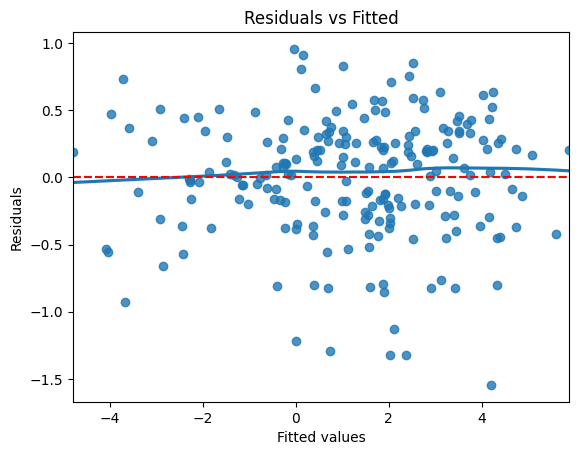

In [43]:
#regression on seasonal
#Q2

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/Seasonal_Rf_avg.csv")

df.columns = df.columns.str.strip()

df["total_fertilizer"] = df["nitrogenconsumptiontonnes"] + df["phosphateconsumptiontonnes"] + df["potashconsumptiontonnes"]
df["unirrigated_area"] = df["area1000hectares"] - df["irrigatedarea1000hectares"]

df["irrigated_plus1"] = df["irrigatedarea1000hectares"] + 1
df["unirrigated_plus1"] = df["unirrigated_area"] + 1

df["log_production"] = np.log(df["production1000tonnes"])
df["log_area"] = np.log(df["area1000hectares"])
df["log_fertilizer"] = np.log(df["total_fertilizer"])
df["log_irrigated"] = np.log(df["irrigated_plus1"])
df["log_unirrigated"] = np.log(df["unirrigated_plus1"])

X = df[["log_area", "log_fertilizer", "log_irrigated", "log_unirrigated", "rf", "salinity"]]
X = sm.add_constant(X)
y = df["log_production"]

model = sm.OLS(y, X).fit()
print(model.summary())

sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.axhline(0, linestyle='--', color='red')
plt.show()


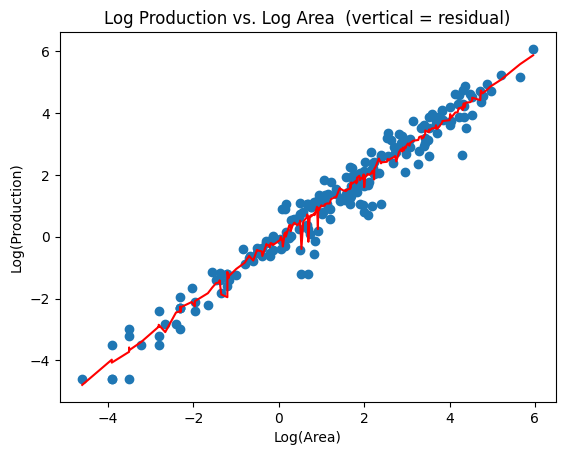

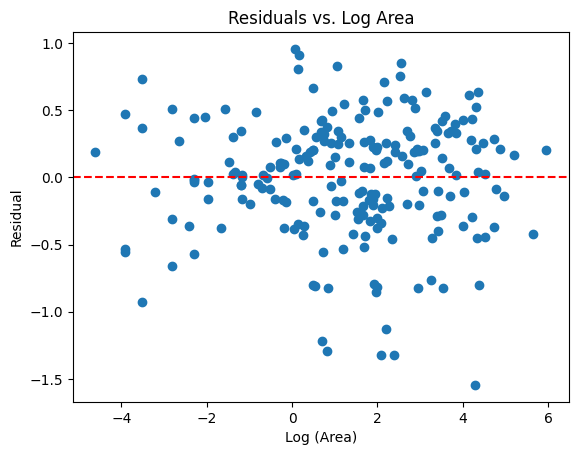

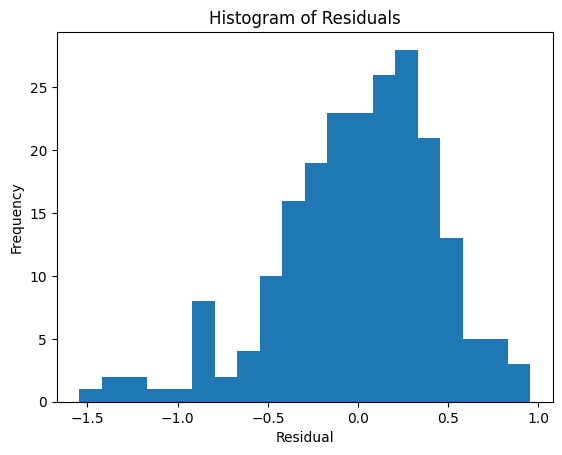

Sum of residuals: -0.00000000


In [44]:
#q4

x_ar = df["log_area"]
y_prod = df["log_production"]
fitted = model.fittedvalues
resid = model.resid

plt.figure()
plt.scatter(x_ar, y_prod)  # the actual points

order = np.argsort(x_ar)
plt.plot(x_ar.iloc[order], fitted.iloc[order], color="red")  # the fitted line

plt.xlabel("Log(Area)")
plt.ylabel("Log(Production)")
plt.title("Log Production vs. Log Area  (vertical = residual)")

plt.figure()
plt.scatter(x_ar, resid)
plt.axhline(0, linestyle="--", color="red")
plt.xlabel("Log (Area)")
plt.ylabel("Residual")
plt.title("Residuals vs. Log Area")

plt.figure()
plt.hist(resid, bins=20)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")

plt.show()

print(f"Sum of residuals: {resid.sum():.8f}")

